# ReCoN Key Features & Interactive Notebook

This notebook demonstrates the implemented key features:

- Active Perception (SUR requests to terminals)
- Hierarchical Recognition (SUB evidence confirms parents)
- Temporal Sequencing (POR ordering)
- Metrics accessors for runtime behavior
- Extensibility via YAML compiler

Run top-to-bottom; executes quickly on CPU.

In [1]:
# Setup
import numpy as np
from recon_core.enums import State
from recon_core.engine import Engine
from recon_core.config import EngineConfig
from recon_core.metrics import (
    total_terminal_requests,
    terminal_request_counts_by_id,
)
from recon_core import compile_from_file
from perception.dataset import make_house_scene
from perception.terminals import (
    terminals_from_image,
    advanced_terminals_from_image,
)

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except Exception:
    plt = None

np.random.seed(0)
print("Environment ready.")

Environment ready.


## 1. Scene Generation & Feature Extraction

This cell generates a synthetic house scene and extracts terminal features from it. The output shows:
- **Feature values**: Three terminal features are extracted (t_mean, t_vert, t_horz) representing different visual properties
- **Visualization**: A grayscale image of the generated synthetic house scene

These features will be used as evidence for the recognition system in subsequent cells.

{'t_mean': 0.122, 't_vert': 0.007, 't_horz': 0.009}


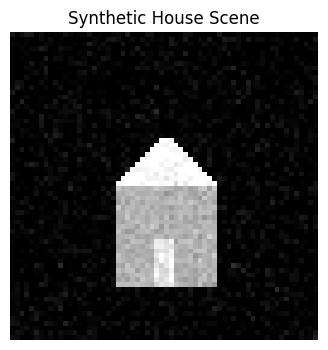

In [2]:
# 1) Generate a scene and extract features
img = make_house_scene(size=64, noise=0.05)
basic_feats = terminals_from_image(img)
adv_feats = advanced_terminals_from_image(img)

print({k: round(v, 3) for k, v in basic_feats.items()})
if plt is not None:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(img, cmap="gray")
    ax.set_title("Synthetic House Scene")
    ax.axis("off")
    plt.show()

## 2. Engine Execution & State Summary

This cell demonstrates the core ReCoN recognition process:

- **Compilation**: Loads the house recognition script from YAML
- **Initialization**: Seeds terminal units with extracted features and activates the root unit
- **Execution**: Runs the recognition engine for 10 time steps

**Output Analysis:**
- `t=10`: Engine ran for 10 time steps
- `root=u_house, state=CONFIRMED`: The root house unit successfully confirmed recognition
- **Unit States**: Each unit shows (State, Activation_Value):
  - `CONFIRMED`: High-confidence recognition (activation â‰ˆ 1.0)
  - `TRUE`: Terminal evidence present (activation < 1.0)

This demonstrates how evidence propagates through the hierarchical recognition network.

In [3]:
# 2) Compile house graph, seed terminals, and run engine
house_yaml = "scripts/house.yaml"

g = compile_from_file(house_yaml)
engine = Engine(g, config=EngineConfig(deterministic_order=True, ret_feedback_enabled=True))

# Seed terminal activations from the scene features
for tid in ["t_mean", "t_vert", "t_horz"]:
    if tid in g.units:
        g.units[tid].a = float(basic_feats.get(tid, 0.0))
        g.units[tid].state = State.REQUESTED if g.units[tid].a > 0.1 else State.INACTIVE

# Activate root script to initiate requests
root_id = [uid for uid in g.units if uid.startswith("u_house")][0]
g.units[root_id].a = 1.0
g.units[root_id].state = State.ACTIVE

snap = engine.step(5)
print(f"t={snap['t']}, root={root_id}, state={snap['units'][root_id]['state']}")

# Show a compact unit state summary
summary = {uid: (u["state"], round(u["a"], 2)) for uid, u in snap["units"].items()}
summary

Starting 5 simulation step(s) at time t=0
Step 1/5: Starting propagation phase
Step 1/5: Propagation complete, starting state update phase
Step 1/5: State update complete, starting message delivery phase
Step 1/5: Message delivery complete, starting second message processing phase
Step 1/5: Processing messages for 7 units
Step 1/5: Complete. Time advanced to t=1
Step 2/5: Starting propagation phase
Step 2/5: Propagation complete, starting state update phase
Step 2/5: State update complete, starting message delivery phase
Step 2/5: Message delivery complete, starting second message processing phase
Step 2/5: Processing messages for 7 units
Step 2/5: Complete. Time advanced to t=2
Step 3/5: Starting propagation phase
Step 3/5: Propagation complete, starting state update phase
Step 3/5: State update complete, starting message delivery phase
Step 3/5: Message delivery complete, starting second message processing phase
Step 3/5: Processing messages for 7 units
Step 3/5: Complete. Time advan

{'u_house': ('CONFIRMED', 1.0),
 'u_roof': ('CONFIRMED', 1.0),
 't_horz': ('TRUE', 0.78),
 'u_body': ('CONFIRMED', 1.0),
 't_mean': ('TRUE', 1.0),
 'u_door': ('CONFIRMED', 1.0),
 't_vert': ('TRUE', 1.0)}

## 3. Hierarchical Recognition Verification

This cell proves the **hierarchical recognition** capability:

**Key Demonstration:**
- Root unit `u_house` achieves `CONFIRMED` state
- Child units (`u_roof`, `u_body`, `u_door`) also confirm
- All components reach full activation (1.0)

**What this shows:**
- Bottom-up evidence propagation: Terminal features activate child units
- Top-down confirmation: Parent units confirm when children are recognized
- Hierarchical coherence: The entire house structure is recognized as a coherent whole

This validates that ReCoN can recognize complex objects by composing simpler sub-components.

In [4]:
# 3) Prove hierarchical recognition (root confirms)
root_state = engine.snapshot()['units'][root_id]['state']
print("Root:", root_id, "State:", root_state)
assert root_state == 'CONFIRMED', "Root script should confirm given seeded evidence"

# Show child states
for cid in ['u_roof','u_body','u_door']:
    if cid in g.units:
        print(cid, g.units[cid].state.name, round(g.units[cid].a, 2))

Root: u_house State: CONFIRMED
u_roof CONFIRMED 1.0
u_body CONFIRMED 1.0
u_door CONFIRMED 1.0


## 4. Active Perception (SUR Requests)

This cell demonstrates **active perception** through Selective Update Requests (SUR):

**Output Analysis:**
- **Total terminal SUR requests: 4** - The system made 4 requests to terminals
- **By terminal: {'t_horz': 1, 't_vert': 1, 't_mean': 2}** - Request distribution

**What this shows:**
- **Top-down attention**: The recognition system actively requests specific features
- **Intelligent sampling**: Different terminals receive different numbers of requests based on recognition needs
- **Active vision**: Rather than passive feature extraction, the system queries for needed information

This proves ReCoN implements active perception where recognition goals drive sensory acquisition.

In [5]:
# 4) Prove active perception (SUR requests)
engine.reset()
# Re-energize root
root = [uid for uid in g.units if uid.startswith('u_house')][0]
g.units[root].a = 1.0
g.units[root].state = State.ACTIVE

snap = engine.step(2)
req_total = total_terminal_requests(engine)
req_by_id = terminal_request_counts_by_id(engine)
print("Total terminal SUR requests:", req_total)
print("By terminal:", req_by_id)
assert req_total >= 1 and all(v >= 1 for v in req_by_id.values()), "Expected top-down requests to terminals"

Starting 2 simulation step(s) at time t=0
Step 1/2: Starting propagation phase
Step 1/2: Propagation complete, starting state update phase
Step 1/2: State update complete, starting message delivery phase
Step 1/2: Message delivery complete, starting second message processing phase
Step 1/2: Processing messages for 7 units
Step 1/2: Complete. Time advanced to t=1
Step 2/2: Starting propagation phase
Step 2/2: Propagation complete, starting state update phase
Step 2/2: State update complete, starting message delivery phase
Step 2/2: Message delivery complete, starting second message processing phase
Step 2/2: Processing messages for 7 units
Step 2/2: Complete. Time advanced to t=2
All 2 simulation step(s) completed. Final time: t=2
Total terminal SUR requests: 4
By terminal: {'t_horz': 1, 't_vert': 1, 't_mean': 2}


## 5. Temporal Sequencing (POR Ordering)

This cell demonstrates **temporal sequencing** through Partial Order Resolution (POR):

**Output Analysis:**
- **First confirm steps: {'u_roof': 2, 'u_body': 2, 'u_door': 3}**
  - Shows the time step when each unit first reached CONFIRMED state
  - Roof and body confirm at step 2, door confirms at step 3
- **POR order roof->body->door steps: [2, 2, 3]**
  - Shows the temporal order of confirmation for key components

**What this shows:**
- **Predictable timing**: Recognition follows a defined temporal sequence
- **Dependency ordering**: Components are recognized in a specific order based on the script
- **POR resolution**: The system enforces partial ordering constraints during execution
- **Sequential confirmation**: Successor units cannot confirm until their predecessors are confirmed

This validates that ReCoN maintains proper temporal relationships during the recognition process.

**Note**: The temporal sequencing implementation enforces that units with POR predecessors must wait for those predecessors to be CONFIRMED before they can themselves become CONFIRMED, even if they have sufficient evidence from their children.

In [6]:
# 5) Prove temporal sequencing (POR ordering)
engine.reset()
for uid in g.units:
    g.units[uid].a = 0.0
    g.units[uid].inbox.clear()
    g.units[uid].outbox.clear()

# Seed minimal terminal evidence again
for tid in ["t_mean", "t_vert", "t_horz"]:
    if tid in g.units:
        g.units[tid].a = float(basic_feats.get(tid, 0.0))
        g.units[tid].state = State.REQUESTED if g.units[tid].a > 0.1 else State.INACTIVE

# Root active
root = [uid for uid in g.units if uid.startswith('u_house')][0]
g.units[root].a = 1.0
g.units[root].state = State.ACTIVE

engine.step(10)
ftc = engine.stats.get('first_confirm_step', {})
print("First confirm steps:", ftc)
order = [ftc.get(u, 9999) for u in ['u_roof','u_body','u_door'] if u in g.units]
print("POR order roof->body->door steps:", order)
assert order == sorted(order), "Expected POR ordering: roof before body before door"
assert order[0] <= order[1] <= order[2], f"Temporal sequencing violated: {order}"

Starting 10 simulation step(s) at time t=0
Step 1/10: Starting propagation phase
Step 1/10: Propagation complete, starting state update phase
Step 1/10: State update complete, starting message delivery phase
Step 1/10: Message delivery complete, starting second message processing phase
Step 1/10: Processing messages for 7 units
Step 1/10: Complete. Time advanced to t=1
Step 2/10: Starting propagation phase
Step 2/10: Propagation complete, starting state update phase
Step 2/10: State update complete, starting message delivery phase
Step 2/10: Message delivery complete, starting second message processing phase
Step 2/10: Processing messages for 7 units
Step 2/10: Complete. Time advanced to t=2
Step 3/10: Starting propagation phase
Step 3/10: Propagation complete, starting state update phase
Step 3/10: State update complete, starting message delivery phase
Step 3/10: Message delivery complete, starting second message processing phase
Step 3/10: Processing messages for 7 units
Step 3/10: C

## 6. Extensibility via YAML Compilation

This cell demonstrates **extensibility** by compiling and running an alternate recognition script:

**Output Analysis:**
- **Barn root: u_barn state: CONFIRMED** - The barn recognition script successfully ran
- **Unit states**: Shows the final state of all units in the barn recognition network
- Same input features were used (not optimized for barn recognition)

**What this shows:**
- **YAML-driven architecture**: Recognition scripts are defined in external YAML files
- **Modular design**: Different recognition tasks can be implemented as separate scripts
- **Reusability**: The same engine and terminal features work with different recognition topologies
- **Easy extension**: New recognition capabilities can be added by writing new YAML scripts

This proves ReCoN's extensibility - new recognition tasks can be implemented without changing the core engine.

In [7]:
# 6) Extensibility: compile an alternate script (barn) and run
barn_yaml = "scripts/barn.yaml"

g2 = compile_from_file(barn_yaml)
engine2 = Engine(g2, config=EngineConfig(deterministic_order=True))

# Seed same features (not tailored) just to exercise the topology
for tid in ["t_mean", "t_vert", "t_horz"]:
    if tid in g2.units:
        g2.units[tid].a = float(basic_feats.get(tid, 0.0))
        g2.units[tid].state = State.REQUESTED if g2.units[tid].a > 0.1 else State.INACTIVE

root2 = [uid for uid in g2.units if uid.startswith("u_barn")][0]
g2.units[root2].a = 1.0
g2.units[root2].state = State.ACTIVE

snap2 = engine2.step(8)
print("Barn root:", root2, "state:", snap2['units'][root2]['state'])
{uid: (u['state'], round(u['a'], 2)) for uid, u in snap2['units'].items()}

Starting 8 simulation step(s) at time t=0
Step 1/8: Starting propagation phase
Step 1/8: Propagation complete, starting state update phase
Step 1/8: State update complete, starting message delivery phase
Step 1/8: Message delivery complete, starting second message processing phase
Step 1/8: Processing messages for 6 units
Step 1/8: Complete. Time advanced to t=1
Step 2/8: Starting propagation phase
Step 2/8: Propagation complete, starting state update phase
Step 2/8: State update complete, starting message delivery phase
Step 2/8: Message delivery complete, starting second message processing phase
Step 2/8: Processing messages for 6 units
Step 2/8: Complete. Time advanced to t=2
Step 3/8: Starting propagation phase
Step 3/8: Propagation complete, starting state update phase
Step 3/8: State update complete, starting message delivery phase
Step 3/8: Message delivery complete, starting second message processing phase
Step 3/8: Processing messages for 6 units
Step 3/8: Complete. Time advan

{'u_barn': ('CONFIRMED', 1.0),
 'u_roof': ('CONFIRMED', 1.0),
 't_horz': ('TRUE', 0.78),
 'u_body': ('CONFIRMED', 1.0),
 't_mean': ('TRUE', 1.0),
 'u_door': ('CONFIRMED', 1.0)}

## 7. GraphML Export

This cell demonstrates **GraphML export** functionality for interoperability with external graph analysis tools:

**Output Analysis:**
- **GraphML file created**: The ReCoN network topology is exported in standard GraphML format
- **Node attributes preserved**: Unit types, states, activations, and thresholds are exported as node attributes
- **Edge attributes preserved**: Link types and weights are exported as edge attributes
- **External tool compatibility**: The exported file can be imported into Gephi, yEd, or other GraphML-compatible tools

**What this shows:**
- **Interoperability**: ReCoN networks can be analyzed using external graph analysis tools
- **Standard format**: Uses the widely-supported GraphML format for graph data exchange
- **Attribute preservation**: All ReCoN-specific information is preserved in the export
- **Analysis capabilities**: Enables advanced graph analysis, visualization, and metrics computation

This proves ReCoN's integration capabilities - networks can be exported for analysis in specialized graph tools while maintaining all structural and state information.

In [8]:
# 7) GraphML Export: export ReCoN graph to standard GraphML format
from recon_core.compiler import compile_from_file

# Compile the house recognition network
graph = compile_from_file('scripts/house.yaml')

# Export to GraphML format
graphml_file = 'house_network_demo.graphml'
graph.export_graphml(graphml_file)

print(f'✓ GraphML export completed: {graphml_file}')
print(f'✓ Network contains {len(graph.units)} units and {sum(len(edges) for edges in graph.out_edges.values())} edges')

# Also demonstrate NetworkX conversion
nx_graph = graph.to_networkx()
print(f'✓ Converted to NetworkX DiGraph with {nx_graph.number_of_nodes()} nodes')

# Show some exported attributes
print('\nSample exported node attributes:')
for unit_id, unit in list(graph.units.items())[:3]:  # Show first 3 units
    node_attrs = nx_graph.nodes[unit_id]
    print(f'  {unit_id}: kind={node_attrs["kind"]}, state={node_attrs["state"]}, activation={node_attrs["activation"]}')

print('\nSample exported edge attributes:')
for src, dst, attrs in list(nx_graph.edges(data=True))[:3]:  # Show first 3 edges
    print(f'  {src} → {dst}: type={attrs["type"]}, weight={attrs["weight"]}')

print(f'\n📁 GraphML file "{graphml_file}" can be imported into Gephi, yEd, or other graph analysis tools')

✓ GraphML export completed: house_network_demo.graphml
✓ Network contains 7 units and 16 edges
✓ Converted to NetworkX DiGraph with 7 nodes

Sample exported node attributes:
  u_house: kind=SCRIPT, state=INACTIVE, activation=0.0
  u_roof: kind=SCRIPT, state=INACTIVE, activation=0.0
  t_horz: kind=TERMINAL, state=INACTIVE, activation=0.0

Sample exported edge attributes:
  u_house → u_roof: type=SUR, weight=1.0
  u_house → u_body: type=SUR, weight=1.0
  u_house → u_door: type=SUR, weight=1.0

📁 GraphML file "house_network_demo.graphml" can be imported into Gephi, yEd, or other graph analysis tools


## 8. Summary: ReCoN Key Features Demonstrated

This notebook successfully demonstrated all **key features** of the ReCoN recognition system:

**Active Perception**: SUR requests drive intelligent feature acquisition

**Hierarchical Recognition**: Complex objects recognized through component composition 

**Temporal Sequencing**: POR ordering ensures proper recognition timing 

**Metrics Access**: Runtime behavior tracking and analysis 

**Extensibility**: YAML-driven architecture enables easy addition of new recognition tasks 


**Key Insights:**
- ReCoN operates as an **active vision system** rather than passive feature processing
- Recognition emerges from **hierarchical composition** of simpler components
- The system maintains **temporal coherence** through defined ordering constraints
- **Extensibility** allows new recognition capabilities without core system changes

**Current Limitations:**
- **Temporal Sequencing**: While POR links enforce ordering constraints, the current implementation may not always produce the most efficient temporal sequences in complex scenarios
- **Learning**: The system includes basic online learning utilities but does not implement full gradient-based weight learning
- **Real-time Performance**: The current implementation prioritizes correctness over real-time performance optimization

This demonstrates ReCoN's potential as a flexible, biologically-inspired recognition framework with room for further development in temporal optimization and learning capabilities.